In [136]:
import itertools
import random as rd
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus

# Smallest Container Problem

The smallest container problem is a classic problem in computational geometry and optimization. It's concerned with finding the smallest possible container that can hold a given set of items or objects. The problem can be framed in different contexts depending on the type of items and containers involved. 

We will consider $n = 15$ circles of random radii $(r_{i})$ within the interval $[1,m = 7]$ to determine the smallest square of length $S$.

In [137]:
rd.seed(12345)
n = 15
m = 7

r = [rd.randint(1,m) for i in range(n)]

combin = list(itertools.combinations(range(n),2))

In [138]:
model = ConcreteModel()

# Locating x,y coordinates for circle centers
model.x = Var(range(n), bounds = (0,sum(r)), within = PositiveReals)
model.y = Var(range(n), bounds = (0,sum(r)), within = PositiveReals)

# Variables matching the distance between circles' radii
model.x2 = Var(list(zip(*combin))[0], list(zip(*combin))[1], bounds = (0,sum(r)**2), within = PositiveReals)
model.y2 = Var(list(zip(*combin))[0], list(zip(*combin))[1], bounds = (0,sum(r)**2), within = PositiveReals)

# Length of one of the sides of the container
model.S = Var(bounds = (0,sum(r)), within = NonNegativeReals)

model.conlist_1 = ConstraintList()

for i,j in combin:
    # Assigning distances between circles' radii
    model.conlist_1.add(model.x2[i,j] == (model.x[i] - model.x[j])**2 )
    model.conlist_1.add(model.y2[i,j] == (model.y[i] - model.y[j])**2 )

    # The sum of the square distance between any two circles must be equal to or greater than
    # the sum of their square radii, ensuring no two circles overlap
    model.conlist_1.add(model.x2[i,j] + model.y2[i,j] >= (r[i] + r[j])**2)

model.conlist_2 = ConstraintList()

for i in range(n):
    # A circle's x,y coordinates must be placed such that it's radii does not exceed the boundary 
    # of the container
    model.conlist_2.add(model.x[i] >= r[i])
    model.conlist_2.add(model.y[i] >= r[i])

    # The size of the container, S, is at least the size of any circle plus its radii
    model.conlist_2.add(model.x[i] + r[i] <= model.S)
    model.conlist_2.add(model.y[i] + r[i] <= model.S)

model.obj = Objective(expr = model.S)

In [141]:
# Solve model
opt = SolverFactory('ipopt')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  <undefined>


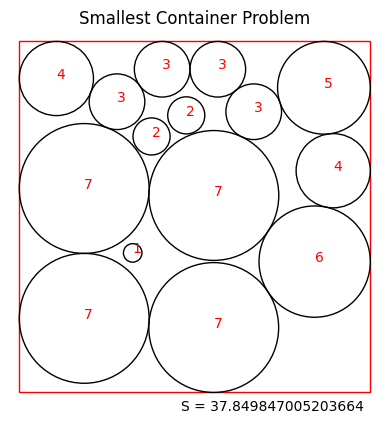

In [142]:
fig, ax = plt.subplots()

circles = [(value(model.x[i]), value(model.y[i])) for i in range(n)]

for i in range(n):
    cir = plt.Circle(circles[i], r[i], color = 'k', fill= False, zorder = 3)
    ax.set_aspect('equal', adjustable='box')
    ax.add_patch(cir)
    ax.text(circles[i][0], circles[i][1], r[i], color = 'r')

square = plt.Rectangle((0,0), value(model.S), value(model.S), edgecolor = 'r', fill = False)
ax.add_patch(square)
ax.text(value(model.S)/2-1.5, -2, f'S = {value(model.S)}')

ax.set_xbound(lower = -1, upper = value(model.S)+1)
ax.set_ybound(lower = -1, upper = value(model.S)+1)

plt.title('Smallest Container Problem')
plt.axis('off')
plt.show()